In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [7]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new4', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new4', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new4', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new4', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [9]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [10]:
test_labels

array([2, 0, 2, 0, 1, 1, 0, 2, 0, 3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 1, 2, 2,
       1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 1, 0,
       0, 3, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 3, 2, 3, 3, 2, 0,
       3, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3,
       2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 1, 2, 3, 3, 1, 1, 0, 1, 2, 1, 0, 3, 0, 0, 0, 3, 2, 1, 1, 1, 3,
       0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 1, 2, 0, 0, 3, 2, 1, 2, 1,
       1, 3, 2, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2,
       3, 1, 2, 1, 0, 1, 3, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 2, 3, 0, 0,
       3, 0, 3, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0,

In [11]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [12]:
train_images.shape

(2913, 256, 256, 1)

In [13]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [14]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16')
test_images = test_images.astype('uint16')

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [15]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [16]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

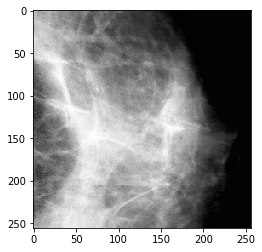

Label: [1. 0. 0. 0.]
[[[ 78  78  78]
  [ 83  83  83]
  [ 74  74  74]
  ...
  [206 206 206]
  [212 212 212]
  [214 214 214]]

 [[ 87  87  87]
  [ 80  80  80]
  [ 88  88  88]
  ...
  [201 201 201]
  [208 208 208]
  [210 210 210]]

 [[ 73  73  73]
  [ 69  69  69]
  [ 83  83  83]
  ...
  [204 204 204]
  [215 215 215]
  [216 216 216]]

 ...

 [[121 121 121]
  [119 119 119]
  [122 122 122]
  ...
  [ 39  39  39]
  [ 25  25  25]
  [ 31  31  31]]

 [[123 123 123]
  [117 117 117]
  [130 130 130]
  ...
  [ 35  35  35]
  [ 30  30  30]
  [ 30  30  30]]

 [[114 114 114]
  [109 109 109]
  [119 119 119]
  ...
  [ 30  30  30]
  [ 28  28  28]
  [ 31  31  31]]]


In [17]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 456

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

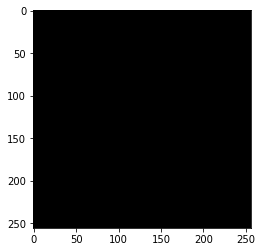

Label: [0. 1. 0. 0.]
[[[ 78  78  78]
  [ 83  83  83]
  [ 74  74  74]
  ...
  [206 206 206]
  [212 212 212]
  [214 214 214]]

 [[ 87  87  87]
  [ 80  80  80]
  [ 88  88  88]
  ...
  [201 201 201]
  [208 208 208]
  [210 210 210]]

 [[ 73  73  73]
  [ 69  69  69]
  [ 83  83  83]
  ...
  [204 204 204]
  [215 215 215]
  [216 216 216]]

 ...

 [[121 121 121]
  [119 119 119]
  [122 122 122]
  ...
  [ 39  39  39]
  [ 25  25  25]
  [ 31  31  31]]

 [[123 123 123]
  [117 117 117]
  [130 130 130]
  ...
  [ 35  35  35]
  [ 30  30  30]
  [ 30  30  30]]

 [[114 114 114]
  [109 109 109]
  [119 119 119]
  ...
  [ 30  30  30]
  [ 28  28  28]
  [ 31  31  31]]]


In [18]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 5

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))

print(train_images[0])

In [19]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(512, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [20]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [21]:
vgg16_fe_drop_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1

In [22]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

In [23]:
vgg16_fe_drop_128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                

In [24]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [33]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 27.6667 - accuracy: 0.2734
Epoch 00001: val_loss improved from inf to 9.44011, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 24s 2s/step - loss: 26.9493 - accuracy: 0.2763 - val_loss: 9.4401 - val_accuracy: 0.2715
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 16.6909 - accuracy: 0.2922
Epoch 00002: val_loss did not improve from 9.44011
11/11 [==============================] - 21s 2s/step - loss: 17.6413 - accuracy: 0.2905 - val_loss: 12.0137 - val_accuracy: 0.3093
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 14.9543 - accuracy: 0.3053
Epoch 00003: val_loss improved from 9.44011 to 8.28438, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==========================

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 3.2615 - accuracy: 0.4219
Epoch 00028: val_loss did not improve from 2.51661
11/11 [==============================] - 21s 2s/step - loss: 3.2164 - accuracy: 0.4219 - val_loss: 2.8689 - val_accuracy: 0.3900
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 3.4616 - accuracy: 0.4131
Epoch 00029: val_loss did not improve from 2.51661
11/11 [==============================] - 20s 2s/step - loss: 3.5139 - accuracy: 0.4139 - val_loss: 3.1577 - val_accuracy: 0.4141
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 3.3864 - accuracy: 0.4187
Epoch 00030: val_loss improved from 2.51661 to 2.49400, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 23s 2s/step - loss: 3.4825 - accuracy: 0.4247 - val_loss: 2.4940 - val_accuracy: 0.4124
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 3.4709 - accuracy: 0.4063
Epoch 00031: val_loss imp

Epoch 56/300
10/11 [==========================>...] - ETA: 1s - loss: 1.6976 - accuracy: 0.4487
Epoch 00056: val_loss did not improve from 1.26320
11/11 [==============================] - 21s 2s/step - loss: 1.6495 - accuracy: 0.4484 - val_loss: 1.3393 - val_accuracy: 0.4192
Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3422 - accuracy: 0.4249
Epoch 00057: val_loss improved from 1.26320 to 1.26162, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 1.3335 - accuracy: 0.4269 - val_loss: 1.2616 - val_accuracy: 0.4278
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3442 - accuracy: 0.4436
Epoch 00058: val_loss did not improve from 1.26162
11/11 [==============================] - 21s 2s/step - loss: 1.3389 - accuracy: 0.4422 - val_loss: 1.3069 - val_accuracy: 0.4296
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2842 - accuracy: 0.4469
Epoch 00059: val_loss imp

10/11 [==========================>...] - ETA: 1s - loss: 1.1781 - accuracy: 0.4734
Epoch 00113: val_loss did not improve from 1.16652
11/11 [==============================] - 21s 2s/step - loss: 1.1780 - accuracy: 0.4698 - val_loss: 1.1817 - val_accuracy: 0.4811
Epoch 114/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1642 - accuracy: 0.4707
Epoch 00114: val_loss did not improve from 1.16652
11/11 [==============================] - 20s 2s/step - loss: 1.1549 - accuracy: 0.4813 - val_loss: 1.2313 - val_accuracy: 0.4536
Epoch 115/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1710 - accuracy: 0.4835
Epoch 00115: val_loss did not improve from 1.16652
11/11 [==============================] - 21s 2s/step - loss: 1.1666 - accuracy: 0.4805 - val_loss: 1.2741 - val_accuracy: 0.4261
Epoch 116/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1771 - accuracy: 0.5063
Epoch 00116: val_loss did not improve from 1.16652
11/11 [============================

In [34]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [35]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [36]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [37]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 139
Epoch [opt]: 109
Valid accuracy [end]: 0.4553
Valid accuracy [opt]: 0.4966
Test accuracy [end]:  0.3542
Test accuracy [opt]:  0.3725
Valid loss [end]: 1.2489
Valid loss [opt]: 1.1665
Test loss [end]:  1.9966
Test loss [opt]:  1.4249


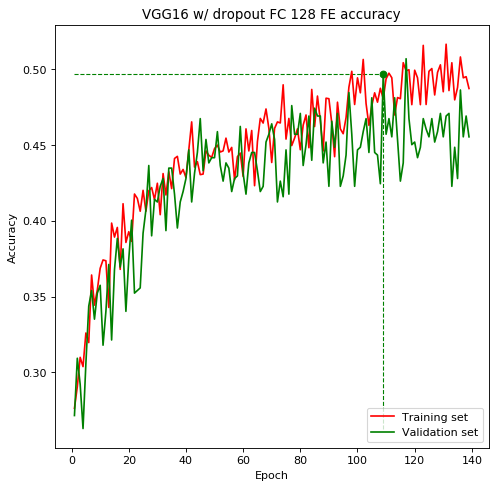

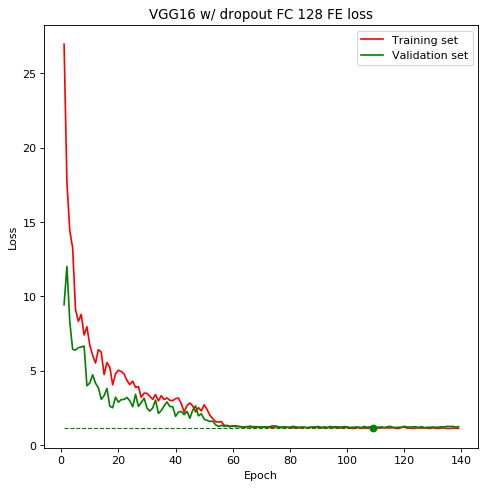

In [38]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 4.9828 - accuracy: 0.2860
Epoch 00001: val_loss improved from inf to 2.80308, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 4.9176 - accuracy: 0.2900 - val_loss: 2.8031 - val_accuracy: 0.2801
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 3.4622 - accuracy: 0.2914
Epoch 00002: val_loss improved from 2.80308 to 2.19431, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 3.4596 - accuracy: 0.2887 - val_loss: 2.1943 - val_accuracy: 0.3024
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 2.9106 - accuracy: 0.2951
Epoch 00003: val_loss improved from 2.19431 to 2.06724, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 2.8

18/19 [===========================>..] - ETA: 1s - loss: 1.4118 - accuracy: 0.3404
Epoch 00027: val_loss did not improve from 1.35066
19/19 [==============================] - 30s 2s/step - loss: 1.4143 - accuracy: 0.3398 - val_loss: 1.3646 - val_accuracy: 0.3351
Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3940 - accuracy: 0.3550
Epoch 00028: val_loss did not improve from 1.35066
19/19 [==============================] - 30s 2s/step - loss: 1.3949 - accuracy: 0.3556 - val_loss: 1.3509 - val_accuracy: 0.3402
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3855 - accuracy: 0.3323
Epoch 00029: val_loss did not improve from 1.35066
19/19 [==============================] - 30s 2s/step - loss: 1.3899 - accuracy: 0.3346 - val_loss: 1.3548 - val_accuracy: 0.3540
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3841 - accuracy: 0.3482
Epoch 00030: val_loss improved from 1.35066 to 1.34679, saving model to vgg16_fe_drop_256

Epoch 56/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3181 - accuracy: 0.3795
Epoch 00056: val_loss improved from 1.33000 to 1.32055, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.3220 - accuracy: 0.3788 - val_loss: 1.3206 - val_accuracy: 0.3780
Epoch 57/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3339 - accuracy: 0.3827
Epoch 00057: val_loss did not improve from 1.32055
19/19 [==============================] - 29s 2s/step - loss: 1.3360 - accuracy: 0.3801 - val_loss: 1.3323 - val_accuracy: 0.3540
Epoch 58/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3192 - accuracy: 0.3804
Epoch 00058: val_loss did not improve from 1.32055
19/19 [==============================] - 29s 2s/step - loss: 1.3216 - accuracy: 0.3767 - val_loss: 1.3208 - val_accuracy: 0.3694
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3174 - accuracy: 0.3863
Epoch 00059: val_loss did

Epoch 85/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3163 - accuracy: 0.3768
Epoch 00085: val_loss did not improve from 1.30022
19/19 [==============================] - 30s 2s/step - loss: 1.3136 - accuracy: 0.3831 - val_loss: 1.3136 - val_accuracy: 0.3763
Epoch 86/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3040 - accuracy: 0.3858
Epoch 00086: val_loss did not improve from 1.30022
19/19 [==============================] - 30s 2s/step - loss: 1.3028 - accuracy: 0.3895 - val_loss: 1.3058 - val_accuracy: 0.3763
Epoch 87/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2991 - accuracy: 0.3872
Epoch 00087: val_loss did not improve from 1.30022
19/19 [==============================] - 30s 2s/step - loss: 1.2986 - accuracy: 0.3891 - val_loss: 1.3063 - val_accuracy: 0.3918
Epoch 88/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3054 - accuracy: 0.3931
Epoch 00088: val_loss did not improve from 1.30022
19/19 [==================

Epoch 114/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2791 - accuracy: 0.4117
Epoch 00114: val_loss did not improve from 1.26618
19/19 [==============================] - 30s 2s/step - loss: 1.2808 - accuracy: 0.4110 - val_loss: 1.2785 - val_accuracy: 0.4330
Epoch 115/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2808 - accuracy: 0.4044
Epoch 00115: val_loss did not improve from 1.26618
19/19 [==============================] - 29s 2s/step - loss: 1.2828 - accuracy: 0.4024 - val_loss: 1.2727 - val_accuracy: 0.4210
Epoch 116/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2825 - accuracy: 0.4140
Epoch 00116: val_loss did not improve from 1.26618
19/19 [==============================] - 29s 2s/step - loss: 1.2852 - accuracy: 0.4114 - val_loss: 1.2813 - val_accuracy: 0.4089
Epoch 117/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2868 - accuracy: 0.4099
Epoch 00117: val_loss did not improve from 1.26618
19/19 [==============

18/19 [===========================>..] - ETA: 1s - loss: 1.2434 - accuracy: 0.4258
Epoch 00143: val_loss did not improve from 1.24959
19/19 [==============================] - 30s 2s/step - loss: 1.2459 - accuracy: 0.4217 - val_loss: 1.2666 - val_accuracy: 0.4227
Epoch 144/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2530 - accuracy: 0.4303
Epoch 00144: val_loss did not improve from 1.24959
19/19 [==============================] - 30s 2s/step - loss: 1.2564 - accuracy: 0.4290 - val_loss: 1.2727 - val_accuracy: 0.3900
Epoch 145/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2637 - accuracy: 0.4181
Epoch 00145: val_loss did not improve from 1.24959
19/19 [==============================] - 30s 2s/step - loss: 1.2642 - accuracy: 0.4221 - val_loss: 1.2625 - val_accuracy: 0.4107
Epoch 146/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2807 - accuracy: 0.4140
Epoch 00146: val_loss did not improve from 1.24959
19/19 [============================

In [27]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [28]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 150
Epoch [opt]: 148
Valid accuracy [end]: 0.3935
Valid accuracy [opt]: 0.4261
Test accuracy [end]:  0.4046
Test accuracy [opt]:  0.4000
Valid loss [end]: 1.2693
Valid loss [opt]: 1.2456
Test loss [end]:  1.2496
Test loss [opt]:  1.2507


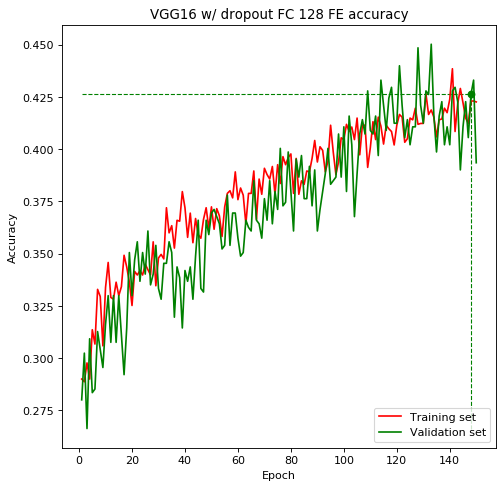

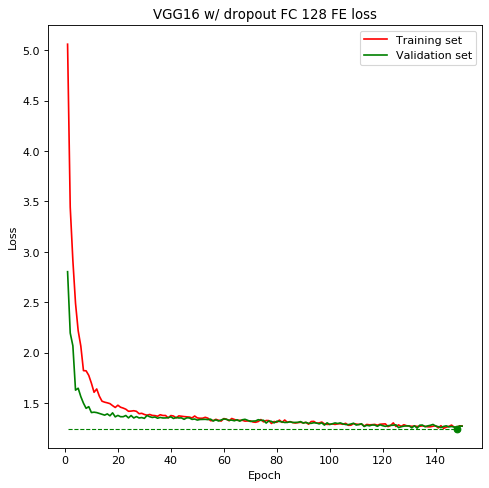

In [34]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [35]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                

In [26]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [27]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2657 - accuracy: 0.4773
Epoch 00001: val_loss improved from inf to 1.20432, saving model to vgg16_ft_1layer_4cl_best.h5
11/11 [==============================] - 25s 2s/step - loss: 1.2670 - accuracy: 0.4766 - val_loss: 1.2043 - val_accuracy: 0.4381
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.2135 - accuracy: 0.4902
Epoch 00002: val_loss improved from 1.20432 to 1.13964, saving model to vgg16_ft_1layer_4cl_best.h5
11/11 [==============================] - 20s 2s/step - loss: 1.2000 - accuracy: 0.4966 - val_loss: 1.1396 - val_accuracy: 0.4742
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.1719 - accuracy: 0.4792
Epoch 00003: val_loss did not improve from 1.13964
11/11 [==============================] - 21

10/11 [==========================>...] - ETA: 1s - loss: 1.0298 - accuracy: 0.5454
Epoch 00028: val_loss did not improve from 1.10752
11/11 [==============================] - 20s 2s/step - loss: 1.0334 - accuracy: 0.5486 - val_loss: 1.1662 - val_accuracy: 0.4863
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0522 - accuracy: 0.5123
Epoch 00029: val_loss improved from 1.10752 to 1.09359, saving model to vgg16_ft_1layer_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 1.0535 - accuracy: 0.5119 - val_loss: 1.0936 - val_accuracy: 0.5103
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0583 - accuracy: 0.5589
Epoch 00030: val_loss did not improve from 1.09359
11/11 [==============================] - 21s 2s/step - loss: 1.0608 - accuracy: 0.5585 - val_loss: 1.1074 - val_accuracy: 0.5120
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0485 - accuracy: 0.5383
Epoch 00031: val_loss did not improve fr

10/11 [==========================>...] - ETA: 1s - loss: 0.9599 - accuracy: 0.5827
Epoch 00057: val_loss improved from 1.06563 to 1.06283, saving model to vgg16_ft_1layer_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 0.9653 - accuracy: 0.5884 - val_loss: 1.0628 - val_accuracy: 0.5137
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0072 - accuracy: 0.5505
Epoch 00058: val_loss did not improve from 1.06283
11/11 [==============================] - 21s 2s/step - loss: 1.0035 - accuracy: 0.5532 - val_loss: 1.0865 - val_accuracy: 0.5155
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9806 - accuracy: 0.5657
Epoch 00059: val_loss did not improve from 1.06283
11/11 [==============================] - 21s 2s/step - loss: 0.9769 - accuracy: 0.5685 - val_loss: 1.0946 - val_accuracy: 0.5000
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9818 - accuracy: 0.5797
Epoch 00060: val_loss did not improve fr

Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9099 - accuracy: 0.6081
Epoch 00087: val_loss did not improve from 1.06283
11/11 [==============================] - 21s 2s/step - loss: 0.9120 - accuracy: 0.6037 - val_loss: 1.1054 - val_accuracy: 0.5292
Epoch 00087: early stopping


In [28]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [29]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 87
Epoch [opt]: 57
Valid accuracy [end]: 0.5292
Valid accuracy [opt]: 0.5137
Test accuracy [end]:  0.3679
Test accuracy [opt]:  0.3328
Valid loss [end]: 1.1054
Valid loss [opt]: 1.0628
Test loss [end]:  2.0159
Test loss [opt]:  2.2249


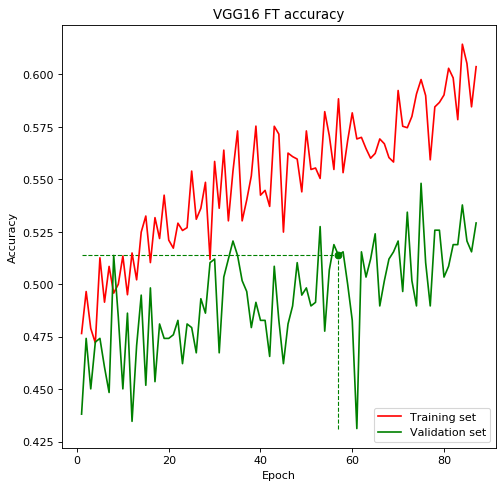

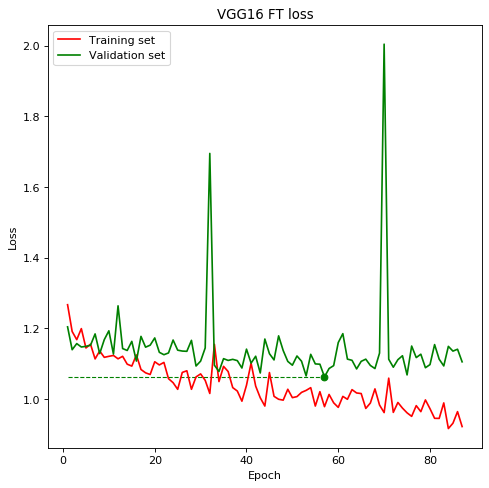

In [30]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [45]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 13,109,508
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [46]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [ ]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1645 - accuracy: 0.4766
Epoch 00001: val_loss improved from inf to 1.15165, saving model to vgg16_ft_2layer_4cl_best.h5
11/11 [==============================] - 20s 2s/step - loss: 1.1547 - accuracy: 0.4790 - val_loss: 1.1517 - val_accuracy: 0.4828
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1619 - accuracy: 0.4836
Epoch 00002: val_loss did not improve from 1.15165
11/11 [==============================] - 22s 2s/step - loss: 1.1630 - accuracy: 0.4787 - val_loss: 1.1536 - val_accuracy: 0.4845
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1649 - accuracy: 0.4826
Epoch 00003: val_loss did not improve from 1.15165
11/11 [==============================] - 20s 2s/step - loss: 1.1691 - accuracy: 0.4797 - val_loss: 1.1993 - val_accuracy: 0.4519
Epoch 4/200
10/11 [====================

Epoch 29/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1117 - accuracy: 0.5047
Epoch 00029: val_loss did not improve from 1.12181
11/11 [==============================] - 20s 2s/step - loss: 1.1122 - accuracy: 0.5111 - val_loss: 1.1458 - val_accuracy: 0.4897
Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1351 - accuracy: 0.5081
Epoch 00030: val_loss did not improve from 1.12181
11/11 [==============================] - 21s 2s/step - loss: 1.1343 - accuracy: 0.5042 - val_loss: 1.1344 - val_accuracy: 0.4845
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1342 - accuracy: 0.5125
Epoch 00031: val_loss did not improve from 1.12181
11/11 [==============================] - 22s 2s/step - loss: 1.1365 - accuracy: 0.5099 - val_loss: 1.1408 - val_accuracy: 0.5017
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 1.1316 - accuracy: 0.4727
Epoch 00032: val_loss did not improve from 1.12181
11/11 [==================

In [ ]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

In [ ]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [ ]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

In [ ]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();